#**Практическое задание №1**

Установка необходимых пакетов:

In [30]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [31]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [32]:
EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1zwkG3yjJNegeGKWvWmaUS3b7jY6o9nG6',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}
name_to_id_dict = {
    'best': '1x1CLOxw19K_ETwUAQ7FMe0I3TuJthdTv',
    'train': '1ONPCEwFOdGDh1VgqXdJbOB97J5hk7fnA',
    'train_small': '1GKPoXUm4wO-fNKFduMrS14ia5mFynKwk',
    'train_tiny' : '1oBec-22X8RGEKizIRTeARGoC-J1ayZm3',
    'test' : '1L_23EijZ3k_BQ0akE_XgKnvvnOvLi2n_',
    'test_small': '1VQ7_o9ptUu5XNC2EWv4R2Vh4LBpUVGXR',
    'test_tiny': '1vqXjYleG1U1ucgkL1FCo7p6uTtGmr25d'
}

Импорт необходимых зависимостей:

In [33]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [34]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        output = f'{name}.npz'
        print(f'Loading dataset {self.name} from npz.')
        gdown.download(f'https://drive.google.com/uc?id={name_to_id_dict[name]}', output, quiet=False)
        #np_obj = np.load(f'/content/drive/MyDrive/{name}.npz') #для проверки раскоментить строки сверху и снизу и закомментить эту
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [36]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [46]:
class Model:

    def __init__(self):
        self.clf = tf.keras.Model()

    def save(self, name: str):
        self.clf.save(f'/content/drive/MyDrive/{name}.keras')

    def load(self, name: str):
        modelfile = f'{name}.keras'
        gdown.download(f'https://drive.google.com/uc?id=18k9mfzA0nUcieoBce2zOM0Jd8IWRxVqg', modelfile, quiet=False)
        self.clf = tf.keras.models.load_model(f'{name}.keras')
        #self.clf = tf.keras.models.load_model(f'/content/drive/MyDrive/{name}.keras')


    def train(self, dataset: Dataset):
        EPOCHS = 20
        IMG_SIZE = 224
        BATCH_SIZE = 4
        NUM_CLASSES = 9

        x_train, x_test, y_train, y_test = train_test_split(
            dataset.images, dataset.labels, test_size=0.3, shuffle=True)
        y_train = tf.one_hot(y_train, NUM_CLASSES)
        y_test = tf.one_hot(y_test, NUM_CLASSES)

        base_model = tf.keras.applications.ResNet50V2(
                                    include_top=False,
                                    weights="imagenet",
                                    input_shape=(IMG_SIZE, IMG_SIZE, 3)
                                    )

        data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),           #LBL1 Augmentation
        tf.keras.layers.RandomRotation(0.2),
        ])
        base_model.trainable = False
        inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
        x = data_augmentation(inputs)
        x = tf.keras.applications.resnet_v2.preprocess_input(x)
        x = base_model(x, training=False)

        x = layers.GlobalAveragePooling2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)

        outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

        self.clf = tf.keras.Model(inputs, outputs)
        self.clf.summary()

        self.clf.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=tf.keras.losses.CategoricalCrossentropy(),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()]
                    )

        earlystopping = callbacks.EarlyStopping(monitor='val_loss',
                                                mode='min',
                                                patience=5,
                                                restore_best_weights=True)

        history = self.clf.fit(x_train,
                            y_train,
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            validation_data = (x_test, y_test), #LBL2 Intermediate Accuracy & Loss
                            verbose=1,
                            callbacks =[earlystopping])

        def plot_hist(hist):
            plt.plot(hist.history['categorical_accuracy'])
            plt.plot(hist.history['val_categorical_accuracy'])
            plt.title('Categorical accuracy')                   #LBL3 Accuracy for epochs plot
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.show()

        plot_hist(history)

    def test_on_dataset(self, dataset: Dataset, limit=None):
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions

    def test_on_image(self, img: np.ndarray):
        img = np.array([img])
        pred = self.clf.predict_on_batch(img)
        pred_decoded = np.argmax(pred, axis=1)
        return pred_decoded[0]


---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [38]:
d_train = Dataset('train_tiny')
d_test = Dataset('test_tiny')

Loading dataset train_tiny from npz.


Downloading...
From (uriginal): https://drive.google.com/uc?id=1oBec-22X8RGEKizIRTeARGoC-J1ayZm3
From (redirected): https://drive.google.com/uc?id=1oBec-22X8RGEKizIRTeARGoC-J1ayZm3&confirm=t&uuid=47c8296a-927a-4e91-853e-c83245a23f8c
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:00<00:00, 113MB/s] 


Done. Dataset train_tiny consists of 900 images.
Loading dataset test_tiny from npz.


Downloading...
From: https://drive.google.com/uc?id=1vqXjYleG1U1ucgkL1FCo7p6uTtGmr25d
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 88.5MB/s]


Done. Dataset test_tiny consists of 90 images.


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0   

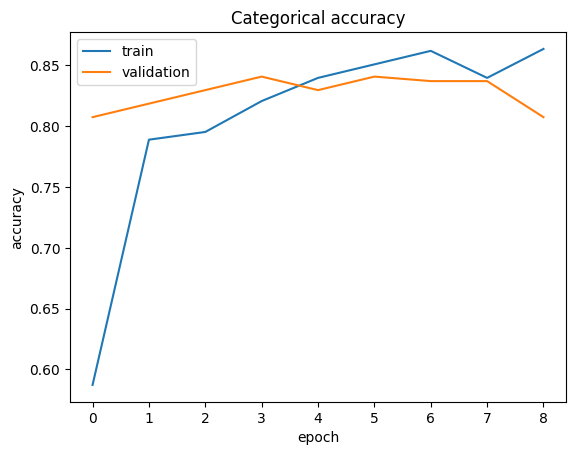

In [39]:
model = Model()
if not EVALUATE_ONLY:
    model.train(d_train)
    #model.save('best')
else:
    model.load('best')

Пример тестирования модели на части набора данных:

In [40]:
# evaluating model on х% of test dataset
predictions = []
for img in tqdm(d_test.images_seq(d_test.n_files), total=d_test.n_files):
    predictions.append(model.test_on_image(img))
pred_1 = model.test_on_dataset(d_test, limit=0.5)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '50% of test')

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

metrics for 50% of test:
	 accuracy 0.8889:
	 balanced accuracy 0.9000:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [41]:
pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

  0%|          | 0/9 [00:00<?, ?it/s]

metrics for 10% of test:
	 accuracy 0.7778:
	 balanced accuracy 0.7778:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Пример тестирования модели на полном наборе данных:

In [42]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

  0%|          | 0/90 [00:00<?, ?it/s]

metrics for test:
	 accuracy 0.8778:
	 balanced accuracy 0.8778:


Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [47]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = final_model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Downloading...
From (uriginal): https://drive.google.com/uc?id=18k9mfzA0nUcieoBce2zOM0Jd8IWRxVqg
From (redirected): https://drive.google.com/uc?id=18k9mfzA0nUcieoBce2zOM0Jd8IWRxVqg&confirm=t&uuid=5632afa8-0334-4322-b2ad-990f89893e5d
To: /content/best.keras
100%|██████████| 95.2M/95.2M [00:00<00:00, 186MB/s]


Loading dataset test_tiny from npz.


Downloading...
From: https://drive.google.com/uc?id=1vqXjYleG1U1ucgkL1FCo7p6uTtGmr25d
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 239MB/s]

Done. Dataset test_tiny consists of 90 images.


  0%|          | 0/90 [00:00<?, ?it/s]

metrics for test-tiny:
	 accuracy 0.9111:
	 balanced accuracy 0.9111:


Отмонтировать Google Drive.

In [44]:
drive.flush_and_unmount()